In [47]:
from helper import get_all_data, get_mult_data, get_sub_data, get_labels

In [48]:
# make nn deterministic
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [49]:
import torch.nn as nn
import torch.optim as optim
class LassoBrainMLP(nn.Module):
    def __init__(self):
        super(LassoBrainMLP, self).__init__()
        # Input is now 100
        self.layer1 = nn.Linear(100, 32) 
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.sigmoid(self.output(x))
    
model = LassoBrainMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
l1_lambda = 0.005 # Increase this to make the map "sparser

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def train_mlp_model(X_avg, y_avg):
    # Select top 100 statistically significant connections
    selector = SelectKBest(score_func=f_classif, k=100)
    X_reduced = selector.fit_transform(X_avg, y_avg)
    selected_indices = selector.get_support(indices=True)

    # Scale the data (Lasso/MLPs require this!)
    scaler = StandardScaler()
    X_final = scaler.fit_transform(X_reduced)

    all_test_preds = []
    all_test_labels = []
    all_test_probs = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print(f"Starting Stratified 5-Fold CV with LASSO regularization...")

    # 2. Change loop to use skf.split
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y_avg)):
        # Split Data
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_avg[train_idx], y_avg[test_idx]

        # Convert to Tensors
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        X_test_t = torch.tensor(X_test, dtype=torch.float32)

        # Initialize model/optimizer
        model = LassoBrainMLP() 
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        l1_lambda = 0.005 

        # 3. Train on the training folds (e.g., 24 participants)
        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = model(X_train_t)
            bce_loss = criterion(outputs, y_train_t)
            l1_penalty = torch.norm(model.layer1.weight, 1)
            total_loss = bce_loss + (l1_lambda * l1_penalty)
            total_loss.backward()
            optimizer.step()

        # 4. Test on the test fold (e.g., 6 participants)
        model.eval()
        with torch.no_grad():
            test_probs_t = model(X_test_t) # This is now a tensor of size (6, 1)
            
            # Convert probabilities to binary predictions (0 or 1)
            # .numpy().flatten() converts tensor to a simple array
            preds = (test_probs_t > 0.5).float().numpy().flatten()
            
            # Use .extend because we are adding multiple values at once
            all_test_probs.extend(test_probs_t.numpy().flatten())
            all_test_preds.extend(preds)
            all_test_labels.extend(y_test)
        
        print(f"Fold {fold+1} complete.")

    # 5. Final Report
    final_acc = accuracy_score(all_test_labels, all_test_preds)
    print(f"\nFinal Stratified K-Fold Accuracy: {final_acc * 100:.2f}%")

    model.eval()
    # Get the absolute sum of weights for each of the 100 features
    # This tells us how much the model "trusts" each brain connection
    feature_weights = torch.abs(model.layer1.weight).sum(dim=0).detach().numpy()
    
    return all_test_labels, all_test_probs, all_test_preds, feature_weights, selected_indices

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plt_roc_curve(all_test_labels, all_test_probs):
    # 1. Convert lists to numpy arrays first
    labels_array = np.array(all_test_labels)
    probs_array = np.array(all_test_probs)

    # 2. Flatten them to ensure they are 1D (removes that extra dimension)
    labels_flat = labels_array.flatten()
    probs_flat = probs_array.flatten()

    # After the loop finishes:
    fpr, tpr, thresholds = roc_curve(labels_flat, probs_flat)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) - MLP')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plt_confusion_matrix(all_test_labels, all_test_preds):
    # 1. Classification Report (Precision, Recall, F1)
    # 0 = TD, 1 = MLD
    target_names = ['Typical Development', 'Math Learning Difficulty']
    print("\nDetailed Classification Report:")
    print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)

    # 3. Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix: MLP with LASSO (LOOCV)')
    plt.show()

In [53]:
def get_winning_conn(feature_weights, selected_indices):
    # Get indices of features with non-zero weights (the 'winners')
    threshold = 1e-4 
    winning_meta_indices = np.where(feature_weights > threshold)[0]
    winning_raw_indices = selected_indices[winning_meta_indices]

    print(f"{len(winning_raw_indices)} connections survived.")

In [54]:
def get_roi_names(index, n_rois=400):
    """Converts a vector index back to ROI pairs (Schaefer 400)."""
    # Create an empty upper triangle matrix
    tri_indices = np.triu_indices(n_rois, k=1)
    roi_a_idx = tri_indices[0][index]
    roi_b_idx = tri_indices[1][index]
    return roi_a_idx, roi_b_idx

def get_top_10_conn(feature_weights, selected_indices):
    # 3. Get the Top 10 Indices
    # argsort gives indices of features from smallest to largest weight
    # [-10:] takes the last 10 (the largest), and [::-1] puts them in descending order
    top_10_meta_indices = np.argsort(feature_weights)[-10:][::-1]

    # Map these meta-indices (0-99) back to the original connectivity indices (0-79799)
    # Assuming 'selected_indices' is the array from your SelectKBest step
    top_10_raw_indices = selected_indices[top_10_meta_indices]

    # 4. Print and Store Results
    print(f"--- Top 10 Connectivity Fingerprints ---")
    top_connections_info = []
    labels = get_labels()
    for i, raw_idx in enumerate(top_10_raw_indices):
        roi_a_idx, roi_b_idx = get_roi_names(raw_idx)
        
        label_a = (labels[roi_a_idx])
        label_b = (labels[roi_b_idx])
        score = feature_weights[top_10_meta_indices[i]]
        
        print(f"Rank {i+1}: Score {score:.4f} | {label_a} <-> {label_b}")
        
        top_connections_info.append({
            'rank': i+1,
            'score': score,
            'roi_a': label_a,
            'roi_b': label_b,
            'indices': (roi_a_idx, roi_b_idx)
        })
    return top_connections_info

# MLP for All Tasks

In [55]:
X_avg, y_avg = get_all_data()
all_test_labels, all_test_probs, all_test_preds, feature_weights, selected_indices = train_mlp_model(X_avg, y_avg)

Starting Stratified 5-Fold CV with LASSO regularization...
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.

Final Stratified K-Fold Accuracy: 83.33%


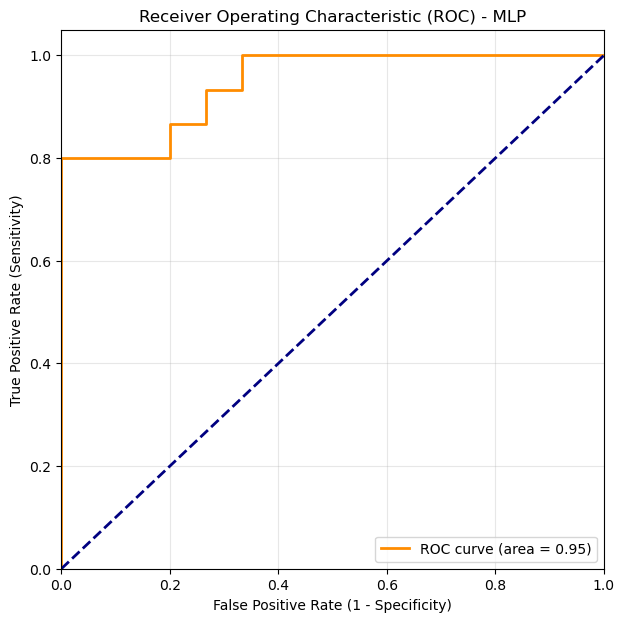

In [56]:
plt_roc_curve(all_test_labels, all_test_probs)


Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       0.86      0.80      0.83        15
Math Learning Difficulty       0.81      0.87      0.84        15

                accuracy                           0.83        30
               macro avg       0.83      0.83      0.83        30
            weighted avg       0.83      0.83      0.83        30



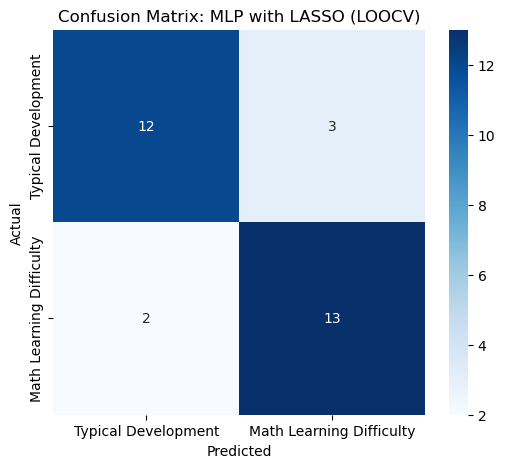

In [57]:
plt_confusion_matrix(all_test_labels, all_test_preds)

In [58]:
get_winning_conn(feature_weights, selected_indices)

100 connections survived.


In [59]:
all_top_10_conn = get_top_10_conn(feature_weights, selected_indices)

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 1.5622 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8
Rank 2: Score 1.4894 | 7Networks_LH_DorsAttn_Post_6 <-> 7Networks_LH_Default_pCunPCC_3
Rank 3: Score 1.2529 | 7Networks_RH_SomMot_17 <-> 7Networks_RH_DorsAttn_FEF_1
Rank 4: Score 0.9369 | 7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Post_14
Rank 5: Score 0.8473 | 7Networks_LH_Default_Par_1 <-> 7Networks_RH_Vis_2
Rank 6: Score 0.8130 | 7Networks_LH_Cont_PFCl_5 <-> 7Networks_RH_Limbic_TempPole_5
Rank 7: Score 0.6419 | 7Networks_RH_Vis_26 <-> 7Networks_RH_DorsAttn_Post_9
Rank 8: Score 0.6220 | 7Networks_LH_Limbic_TempPole_5 <-> 7Networks_LH_Cont_PFCl_1
Rank 9: Score 0.3802 | 7Networks_LH_Vis_25 <-> 7Networks_RH_Cont_Par_2
Rank 10: Score 0.3639 | 7Networks_LH_Vis_27 <-> 7Networks_RH_DorsAttn_FEF_3


# MLP for Mult

In [60]:
X_avg_m, y_avg_m = get_mult_data()
all_test_labels_m, all_test_probs_m, all_test_preds_m, feature_weights_m, selected_indices_m = train_mlp_model(X_avg_m, y_avg_m)

Starting Stratified 5-Fold CV with LASSO regularization...
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.

Final Stratified K-Fold Accuracy: 90.00%


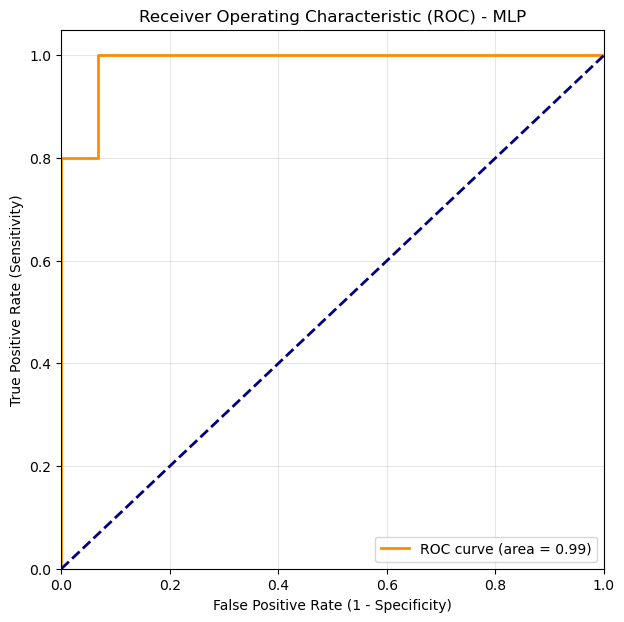

In [61]:
plt_roc_curve(all_test_labels_m, all_test_probs_m)


Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       1.00      0.80      0.89        15
Math Learning Difficulty       0.83      1.00      0.91        15

                accuracy                           0.90        30
               macro avg       0.92      0.90      0.90        30
            weighted avg       0.92      0.90      0.90        30



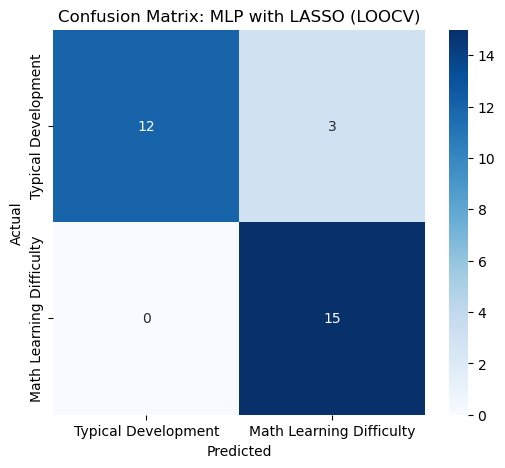

In [62]:
plt_confusion_matrix(all_test_labels_m, all_test_preds_m)

In [63]:
get_winning_conn(feature_weights_m, selected_indices_m)

100 connections survived.


In [64]:
mult_top_10_conn = get_top_10_conn(feature_weights_m, selected_indices_m)

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 2.3119 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8
Rank 2: Score 1.1638 | 7Networks_LH_DorsAttn_Post_1 <-> 7Networks_RH_Vis_11
Rank 3: Score 0.7607 | 7Networks_RH_Vis_26 <-> 7Networks_RH_DorsAttn_Post_13
Rank 4: Score 0.7269 | 7Networks_LH_Cont_PFCl_5 <-> 7Networks_RH_Limbic_TempPole_5
Rank 5: Score 0.7098 | 7Networks_LH_Limbic_TempPole_2 <-> 7Networks_RH_SomMot_35
Rank 6: Score 0.6254 | 7Networks_RH_Vis_26 <-> 7Networks_RH_DorsAttn_Post_9
Rank 7: Score 0.5825 | 7Networks_LH_SalVentAttn_Med_4 <-> 7Networks_RH_Default_Temp_2
Rank 8: Score 0.3290 | 7Networks_LH_Default_Temp_8 <-> 7Networks_RH_Cont_pCun_2
Rank 9: Score 0.3136 | 7Networks_RH_SomMot_25 <-> 7Networks_RH_DorsAttn_Post_13
Rank 10: Score 0.3127 | 7Networks_RH_Vis_17 <-> 7Networks_RH_Default_PFCdPFCm_12


# MLP for Sub

In [65]:
X_avg_s, y_avg_s = get_sub_data()
all_test_labels_s, all_test_probs_s, all_test_preds_s, feature_weights_s, selected_indices_s = train_mlp_model(X_avg_s, y_avg_s)

Starting Stratified 5-Fold CV with LASSO regularization...
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.

Final Stratified K-Fold Accuracy: 86.67%


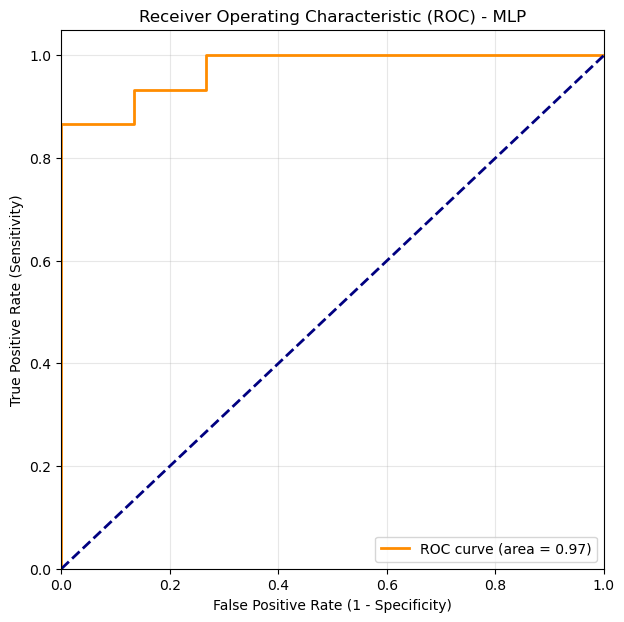

In [66]:
plt_roc_curve(all_test_labels_s, all_test_probs_s)


Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       0.87      0.87      0.87        15
Math Learning Difficulty       0.87      0.87      0.87        15

                accuracy                           0.87        30
               macro avg       0.87      0.87      0.87        30
            weighted avg       0.87      0.87      0.87        30



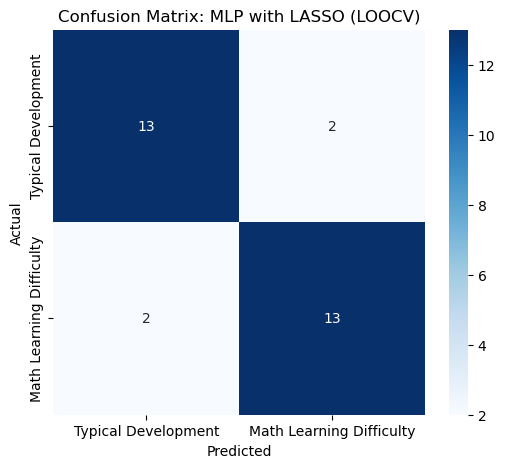

In [67]:
plt_confusion_matrix(all_test_labels_s, all_test_preds_s)

In [68]:
get_winning_conn(feature_weights_s, selected_indices_s)

100 connections survived.


In [69]:
sub_top_10_conn = get_top_10_conn(feature_weights_s, selected_indices_s)

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 1.8880 | 7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Post_14
Rank 2: Score 1.4269 | 7Networks_LH_SomMot_5 <-> 7Networks_RH_Cont_PFCl_5
Rank 3: Score 1.3267 | 7Networks_LH_SomMot_29 <-> 7Networks_LH_Default_Par_2
Rank 4: Score 1.2185 | 7Networks_LH_Default_Par_1 <-> 7Networks_RH_Vis_2
Rank 5: Score 1.1521 | 7Networks_LH_Vis_20 <-> 7Networks_RH_SomMot_32
Rank 6: Score 0.8584 | 7Networks_LH_Default_Temp_8 <-> 7Networks_RH_Default_PFCdPFCm_6
Rank 7: Score 0.6393 | 7Networks_LH_Vis_25 <-> 7Networks_RH_Cont_Par_2
Rank 8: Score 0.4046 | 7Networks_LH_Vis_20 <-> 7Networks_RH_Cont_PFCl_4
Rank 9: Score 0.3334 | 7Networks_LH_SomMot_32 <-> 7Networks_RH_Vis_19
Rank 10: Score 0.2687 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_Cing_2
